# objective:
* predict FVC for every possible week of the patients (only last 3 are being considered for kaggle's scoring)
* add data series with the log likelihood (confidence) of the predictions and predict the FVC for every possible week of each patient

In [1]:
%matplotlib inline
import pickle
import pydicom
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy
from fastai.basics import *

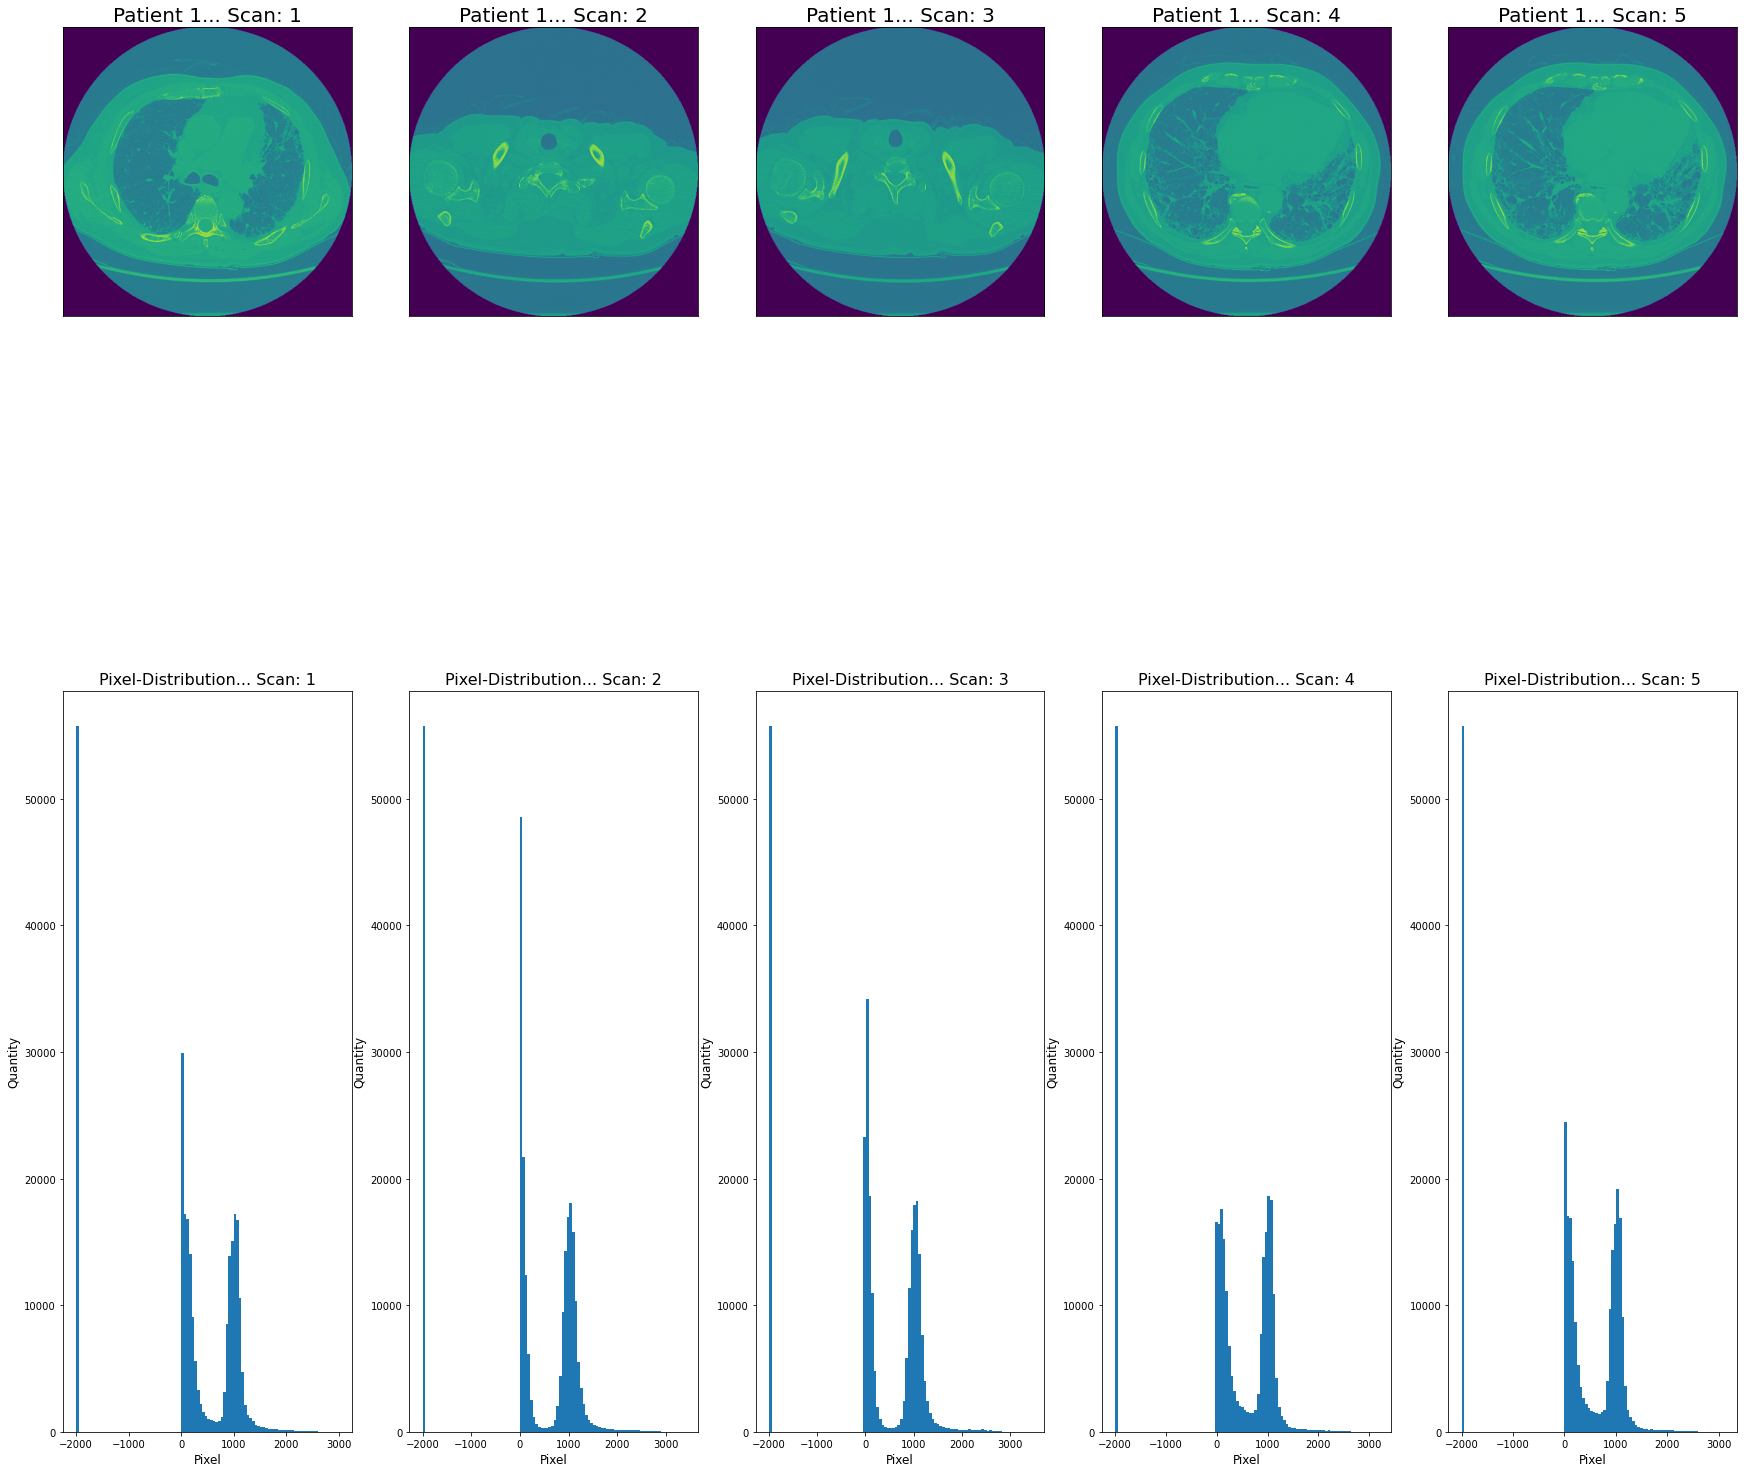

In [2]:
train_path = '../input/osic-pulmonary-fibrosis-progression/train'
test_path = '../input/osic-pulmonary-fibrosis-progression/test'

fig = plt.figure(figsize=(30,30))
for i in range(5):
    #scans
    ax1 = fig.add_subplot(2, 5, i+1, xticks=[], yticks = [])
    ax1.set_title('Patient 1... Scan: ' + str(i+1), fontsize=20)
    scan = os.path.join(train_path, os.listdir(train_path)[2])
    scan = os.path.join(scan, os.listdir(scan)[i])
    scan = pydicom.dcmread(scan)
    ax1.imshow(scan.pixel_array)
    
    #histograms
    scan_pixel = scan.pixel_array.flatten()
    ax2 = fig.add_subplot(2, 5, i+6)
    ax2.hist(scan_pixel, bins=100)
    ax2.set_xlabel('Pixel', fontsize=12)
    ax2.set_ylabel('Quantity', fontsize=12)
    ax2.set_title('Pixel-Distribution... Scan: ' + str(i+1), fontsize=16)

In [3]:
# Load the scans in given PATIENT'S folder path in the right order
def load_scan(path):
    try:
        slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path) if s.endswith('ipynb') == False]
        slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))        

        try:
            slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2]) #assume that the slice thickness is constant throughout all scans of the particular patient
        except:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)


        for s in slices:
            s.SliceThickness = slice_thickness
        return slices
    
    except: #load_scan(2) --> why? because: dicom files with missing data about location will raise an error when you try to sort them by these values
        slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.InstanceNumber), reverse=True)

        return slices

above you'll notice that a row belongs to a patient's visits for testing/scanning, that means: multiple rows per patient   
also...there are a few non-numerical data series, we are going to deal with that later on

In [4]:
def get_pixels_hu(slices):
    image = (np.stack([s.pixel_array for s in slices])).astype(np.int16) #stack all ct-scan slices to a full image(which only consists of integer values)
    image[image == -2000] = 0
    
    for s in range(len(slices)):
        intercept = slices[s].RescaleIntercept
        slope = slices[s].RescaleSlope
        
        if slope != 1:
            image[s] = slope * image[s].astype(np.float64)
            image[s] = image[s].astype(np.int16)
        
        image[s] += np.int16(intercept)
        
    return np.array(image, dtype=np.int16)

In [5]:
train_path = '../input/osic-pulmonary-fibrosis-progression/train'
test_path = '../input/osic-pulmonary-fibrosis-progression/test'
#sorted IDs:
##train
sorted_train_path_list = os.listdir(train_path)
sorted_train_path_list.sort()
##test
sorted_test_path_list = os.listdir(test_path)
sorted_test_path_list.sort()

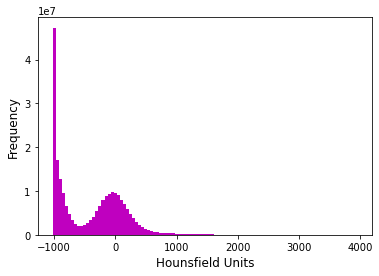

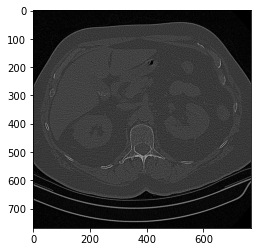

In [6]:
#plotting results after converting image to hounsfield units scaled image
image_in_hounsfield = get_pixels_hu(load_scan(os.path.join(train_path, sorted_train_path_list[1])))
pixels = get_pixels_hu(load_scan(os.path.join(train_path, sorted_train_path_list[1]))).flatten()

plt.hist(pixels, bins=100, color='m') #histogram of all of second patient's pixels inside of all scans
plt.xlabel('Hounsfield Units', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

plt.imshow(image_in_hounsfield[0], cmap=plt.cm.gray) #grayscaled image of scan in hounsfield units
plt.show()

In [7]:
def resample(image, scan, new_spacing=[1,1,1]):
    #determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32) 

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [8]:
#inputs for resampling
slices = load_scan(os.path.join(train_path, sorted_train_path_list[1])) #returns a list of slices in order and with corrected slice thickness
image_resampled, spacing = resample(get_pixels_hu(slices), slices) #converts the slices to hounsfield units (standard format for CT-scans) and stacks them to create a full image 

In [9]:
print('shape before resampling', get_pixels_hu(slices).shape)

shape before resampling (394, 768, 768)


In [10]:
print('shape after resampling', image_resampled.shape)

shape after resampling (315, 374, 374)


In [ ]:
x = image_resampled.flatten()

fig = plt.figure(figsize=(12,12))
plt.title('flattening resampled scans')
plt.xlabel('pixel values')
plt.ylabel('amount')
plt.xticks(np.arange(min(x) // 100 * 100, max(x) // 100 * 100, 100.0), rotation=45)
plt.hist(x = x, bins=500)
plt.show()

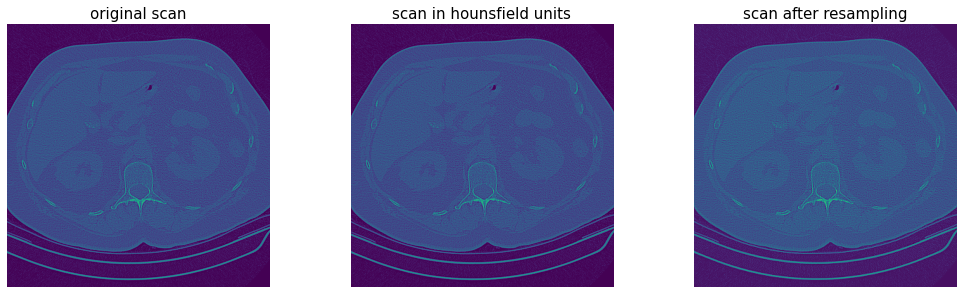

In [12]:
num = 0
images = [slices[num].pixel_array, get_pixels_hu(slices)[num], image_resampled[num]]
titles = ['original scan', 'scan in hounsfield units', 'scan after resampling']

f, ax = plt.subplots(1,3, figsize=(15,10))
f.tight_layout(pad=5)

for i in range(3):
    ax[i].set_title(titles[i], fontsize = 15)
    ax[i].imshow(images[i])
    ax[i].axis('off')

In [13]:
%%capture
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random

def animate_original_slices():

    fig = plt.figure(figsize=(7, 7))
    patient = 0

    pat = load_scan(os.path.join(train_path, sorted_train_path_list[patient]))

    ims = []
    for i,j in enumerate(pat):
        im = plt.imshow(pat[i].pixel_array, animated=True, cmap=plt.cm.bone)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=25, blit=False, repeat_delay=1000)
    
    return ani

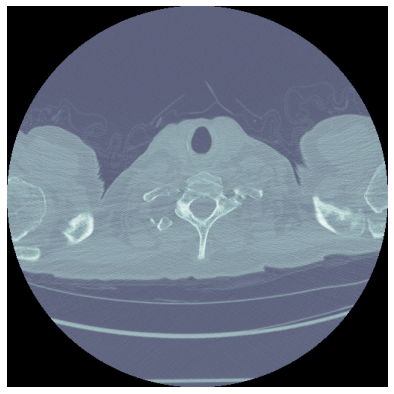

In [14]:
# show animation
HTML(animate_original_slices().to_html5_video())

In [15]:
%%capture
from skimage.transform import resize
import matplotlib.animation as animation
from IPython.display import HTML
import random

def animate_preprocessed_slices():
    fig = plt.figure(figsize=(7, 7))
    patient = 0


    pat = load_scan(os.path.join(train_path, sorted_train_path_list[patient]))
    
    x, z = resample(get_pixels_hu(pat), pat)
    x = resize(x, (30,300,300))

    ims = []
    for i in range(x.shape[0]):
        slc = x[i]
        im = plt.imshow(slc, animated=True, cmap=plt.cm.bone)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=25, blit=False, repeat_delay=1000)
    
    return ani

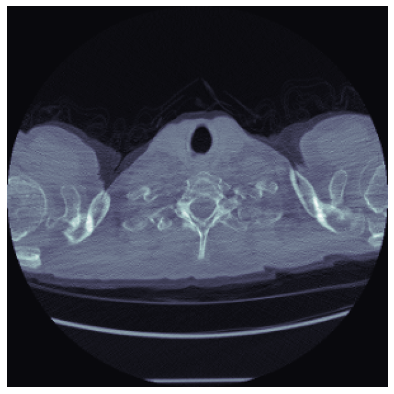

In [16]:
# show animation
HTML(animate_preprocessed_slices().to_html5_video())

In [17]:
def save_dimensions_of_ct_scans(): #resampling takes long...save all the dimensions of all resampled slices
    train_path = '../input/osic-pulmonary-fibrosis-progression/train'

    rows = []
    cols = []
    dims = []

    for num, s in enumerate(sorted_train_path_list):
        p = os.path.join(train_path, s)
        l = load_scan(p)

        try:
            #pixels = get_pixels_hu(l)
            pixels, spacing = resample(get_pixels_hu(l), l)
        except:
            dims.append(-1)
            rows.append(-1)
            cols.append(-1)
            continue
        print(pixels.shape)
        dims.append(pixels.shape[0])
        rows.append(pixels.shape[1])
        cols.append(pixels.shape[2])

    dims_np = np.array(dims)
    rows_np = np.array(rows)
    cols_np = np.array(cols)

    data = [dims_np, rows_np, cols_np]

    with open('DimensionsAfterResamplingInDRC.pkl', 'wb') as outfile:
        pickle.dump(data, outfile, pickle.HIGHEST_PROTOCOL)


    print('max dims:', max(dims))
    print('max rows:', max(rows))
    print('max cols:', max(cols))

# Start *Testing Zoom*
* testing zooming functions from scipy, opencv and skimage

In [18]:
#zooming with scipy
from scipy.ndimage import zoom

def plot_zoom(patient_index = 0, slice_ = 0):
    arr = get_pixels_hu(load_scan(os.path.join(train_path, sorted_train_path_list[patient_index])))

    f, axes = plt.subplots(ncols = 5, nrows = 1, figsize=(20, 20))
    axes[0].imshow(arr[slice_])
    axes[0].set_title('Before zooming in')
    axes[0].axis('off')
    print('original shape:', arr.shape)

    
    for i in range(4):
        arr2 = zoom(arr, ((i+1) * 0.2, (i+1) * 0.2, (i+1) * 0.2))
        axes[i+1].imshow(arr2[slice_])
        axes[1+i].set_title('after zooming in with ' + str(round((i+1) * 0.2, 1)))
        axes[i+1].axis('off')
        print('zooming by ' + str(round((i+1) * 0.2, 1)) + ': new shape', arr2.shape)
    plt.show()                    

original shape: (30, 512, 512)
zooming by 0.2: new shape (6, 102, 102)
zooming by 0.4: new shape (12, 205, 205)
zooming by 0.6: new shape (18, 307, 307)
zooming by 0.8: new shape (24, 410, 410)


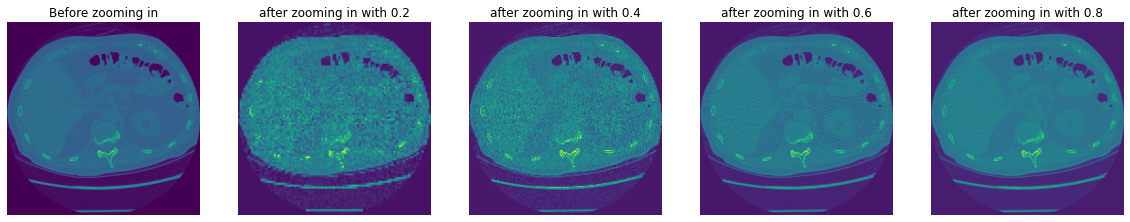

In [19]:
plot_zoom()

In [20]:
#zooming with skimage --> better option !!
from skimage.transform import resize

def plot_zoom2(patient_index = 0, slice_ = 0):
    arr = get_pixels_hu(load_scan(os.path.join(train_path, sorted_train_path_list[patient_index])))

    f, axes = plt.subplots(ncols = 2, nrows = 1, figsize=(20, 20))
    axes[0].imshow(arr[slice_])
    axes[0].set_title('Before zooming in')
    axes[0].axis('off')
    print('original shape:', arr.shape)

    print("...")
    arr2 = resize(arr, (20, 300, 300))
    print('new shape, after zooming:', arr2.shape)
    axes[1].imshow(arr2[slice_])
    axes[1].set_title('after zooming')
    axes[1].axis('off')
    plt.show()

original shape: (30, 512, 512)
...
new shape, after zooming: (20, 300, 300)


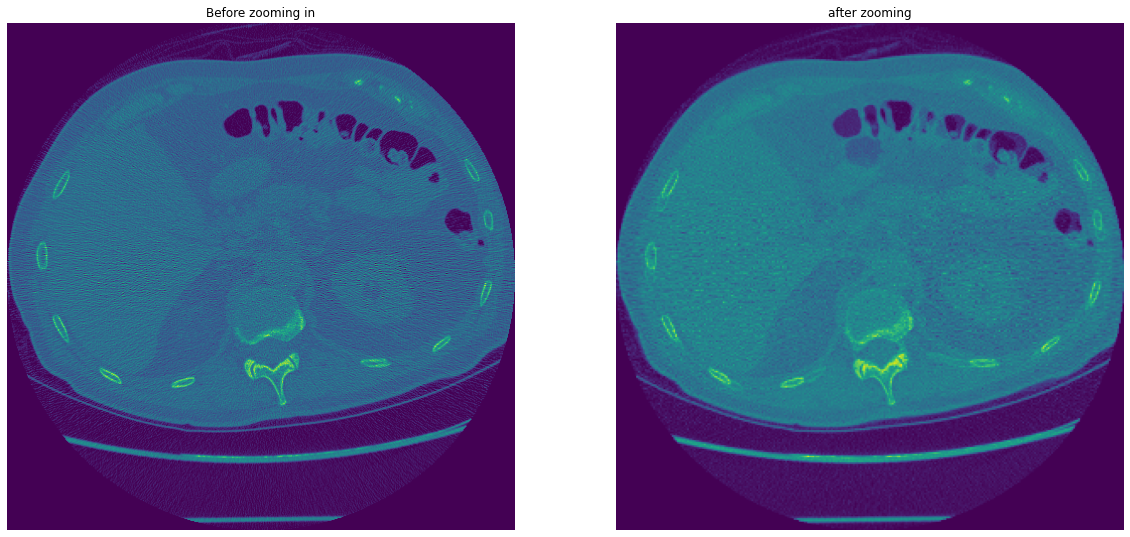

In [21]:
plot_zoom2()

In [22]:
#zooming with opencv....kind of looks the same as skimage, but this here is more annoying to use --> lets go with skimage :-)
import cv2

def plot_zoom3(patient_index = 0, slice_ = 0):
    arr = get_pixels_hu(load_scan(os.path.join(train_path, sorted_train_path_list[patient_index])))

    f, axes = plt.subplots(ncols = 2, nrows = 1, figsize=(20, 20))
    axes[0].imshow(arr[slice_])
    axes[0].set_title('Before zooming in')
    axes[0].axis('off')
    print('original shape:', arr.shape)

    print("...")
    arr2 = cv2.resize(arr[0], dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
    print('new shape, after zooming:', arr2.shape)
    axes[1].imshow(arr2)
    axes[1].set_title('after zooming')
    axes[1].axis('off')
    plt.show()     

original shape: (30, 512, 512)
...
new shape, after zooming: (300, 300)


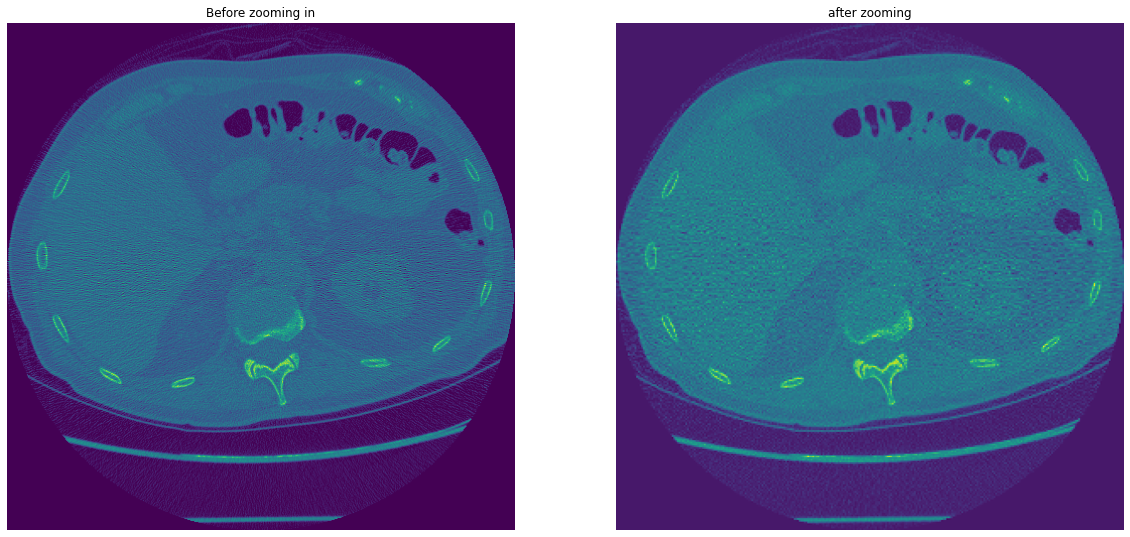

In [23]:
plot_zoom3()

# END *Testing Zoom*

# Start *A*
*  remove images with dimensions who deviate a lot from the mean
*  for example mean ~ (300,350,350) ... outliers ~ (1000,768,768)

In [24]:
import pickle
import numpy as np

def load_dimensions_of_ct_scans():
    with open('../input/correcteddimensionsofctscans/CorrectedDimensionsAfterResamplingInDRC.pkl', 'rb') as infile:
        dimensions_of_ct_scans = pickle.load(infile)

    print('mean channels:', np.mean(dimensions_of_ct_scans[0]))
    print('mean rows:', np.mean(dimensions_of_ct_scans[1]))
    print('mean columns:', np.mean(dimensions_of_ct_scans[2]))

    return dimensions_of_ct_scans

In [25]:
#plotting the number of dimensions, rows, columns to see if there are outlier:
import matplotlib.pyplot as plt

def plot_number_of_dims(dimensions_of_ct_scans = load_dimensions_of_ct_scans()):
    dimension_labels = ['channels', 'rows', 'columns']
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()

    for i in range(3):
        ax.hist(dimensions_of_ct_scans[i], alpha=0.5, label=dimension_labels[i], bins = 250)
    ax.legend(fontsize=15)
    ax.set_xlabel('Size', fontsize=14)
    ax.set_ylabel('Quantity', fontsize=14)
    plt.show()

mean channels: 315.0625
mean rows: 371.25
mean columns: 373.4318181818182


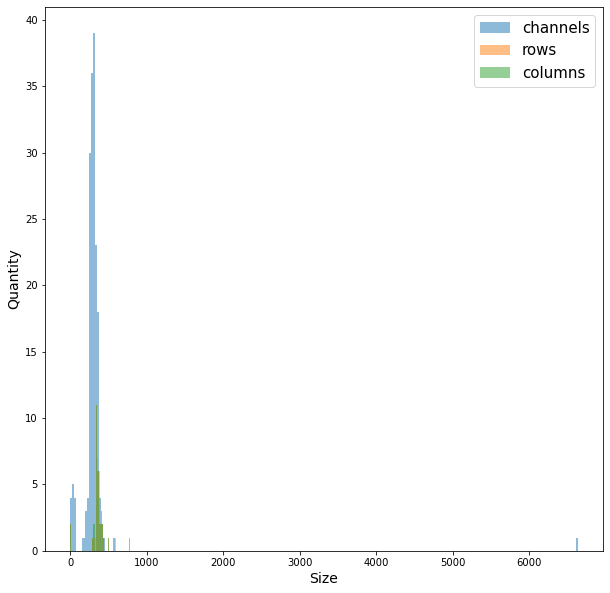

In [26]:
plot_number_of_dims()

we can clearly see we have a few outliers --> some are 0 or near 0 and one or two are way over 6000\
we dont need them to add to the noise of the data

In [27]:
#plotting the number of dimensions, rows, columns --> without the heaviest outliers:
def plot_hist_of_dimensions(dimensions_of_ct_scans = load_dimensions_of_ct_scans()):
    import matplotlib.pyplot as plt

    dimension_labels = ['channels', 'rows', 'columns']
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot()

    for i in range(3):
        ax.hist(dimensions_of_ct_scans[i], alpha=0.5, label=dimension_labels[i], bins = 500)
        ax.set_xlim(150, 450)
    ax.legend(fontsize=15)
    ax.set_xlabel('Size', fontsize=14)
    ax.set_ylabel('Quantity', fontsize=14)
    plt.show()

mean channels: 315.0625
mean rows: 371.25
mean columns: 373.4318181818182


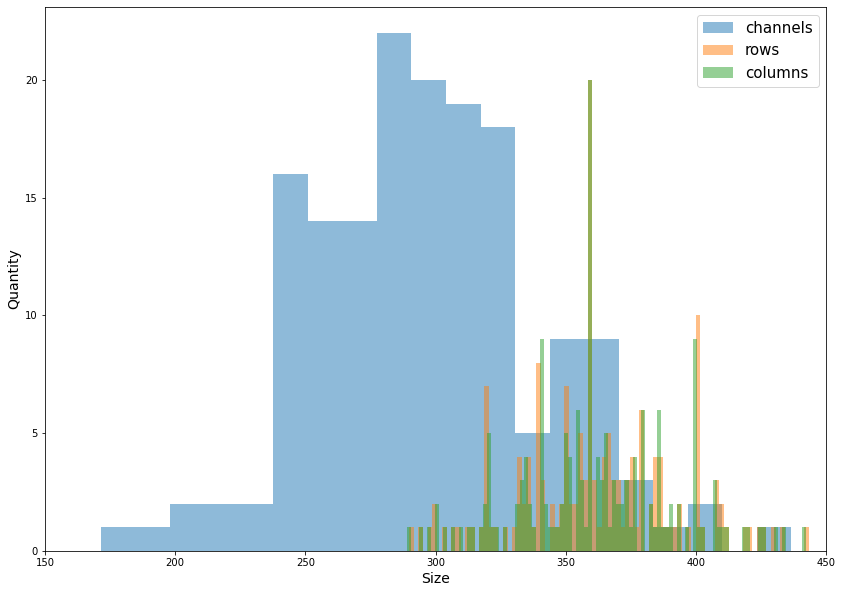

In [28]:
plot_hist_of_dimensions()

looks better without the outliers --> WARNING: does NOT mean that this is better, I'm just testing it out like this for now!

In [29]:
# create a dictionary of patient indeces which have outliers as ct scans --> going to be removed from dataset
def get_outlierpatients_indeces(dimensions_of_ct_scans = load_dimensions_of_ct_scans(), min_ = 150, max_ = 450):
    dic = {}
    length = 0
    results = []

    for i in range(3):
        results.append(np.where((dimensions_of_ct_scans[i] < min_) | (dimensions_of_ct_scans[i] > max_) | (dimensions_of_ct_scans[i] == -1)))
# the -1 above --> the -1 in the lists of the loaded ct scans stands for not working ct scans without gdcm --> getting rid of these as well
    for i in range(3): # we are going to iterate over 3 lists, different lengths possible --> find longest of them to use it in the next loop as length
        if len(results[i][0]) > length:
            length = len(results[i][0])

    for index in range(length):
        for i in range(3):
            try:
                if results[i][0][index] not in dic:
                    dic[results[i][0][index]] = 1
            except:
                continue
    print('indeces of patients, we are going to remove: \n'+ str(dic.keys()) + '\n')
    print('number of patients, who are going to be removed:', len(dic))
    
    return dic

mean channels: 315.0625
mean rows: 371.25
mean columns: 373.4318181818182


above: returns a dictionary with all indeces of sorted_train_path_list where any of the dimensions is considered an outlier by me, also indeces with not working slices (require gdcm which I somehow could not get to work on Kaggle)

In [30]:
# remove these outlier patients from the csv and from the trainfolder containing the ct scans: 
def removing_outliers(dic = get_outlierpatients_indeces()):
    new_sorted_train_id_list = [sorted_train_path_list[x] for x in range(len(sorted_train_path_list)) if x not in dic.keys()]

    return new_sorted_train_id_list

indeces of patients, we are going to remove: 
dict_keys([3, 21, 5, 24, 12, 32, 13, 55, 56, 25, 61, 71, 34, 76, 37, 78, 38, 95, 50, 96, 104, 139, 157, 141, 171, 172])

number of patients, who are going to be removed: 26


based on on the dictionary from before: Replicate the sorted_train_path_list without the outlier and not working patients\
--> returns filtered patients

# remember the goal is to remove not-working patients
**that means:**
* we created a new list of patients...the filtered patients list
    --> we now only want to see the **filtered** patients data in any data source:
 *         we have a csv file --> about to be filtered
 *         we have a training and test set for the slices of each patient --> about to be filtered and **resized** as well

In [32]:
# create dataset containing only ct scans of not-outlier patients
from skimage.transform import resize

def check_if_resizing_works(train_id_list = removing_outliers(dic = get_outlierpatients_indeces(dimensions_of_ct_scans = load_dimensions_of_ct_scans())), path = '../input/osic-pulmonary-fibrosis-progression/train'):
                            
    for i in range(len(train_id_list)):
        a, b = resample(get_pixels_hu(load_scan(os.path.join(path, train_id_list[i]))), load_scan(os.path.join(path, train_id_list[i])))
        c = resize(a, (30, 300, 300))
        print('shape of', str(i) + "'th image:", a.shape)
        print('shape of', str(i) + "'th image after resizing:", c.shape)
        if i >= 4:
            break

mean channels: 315.0625
mean rows: 371.25
mean columns: 373.4318181818182
indeces of patients, we are going to remove: 
dict_keys([3, 21, 5, 24, 12, 32, 13, 55, 56, 25, 61, 71, 34, 76, 37, 78, 38, 95, 50, 96, 104, 139, 157, 141, 171, 172])

number of patients, who are going to be removed: 26


ok it works, if you check it with the unfiltered patients list, it will throw an error before the 10th attempt of resizing the ct slices!\
so what happens next? --> save filtered training ct scans so we don't have to use resizing and all that comes with it every time

In [34]:
def save_new_csv(patients = removing_outliers()):
    #create new dataframe containing all the patients after filtering out the outliers
    data_path = '../input/osic-pulmonary-fibrosis-progression/train.csv'
    train_df = pd.read_csv(data_path) #before filtering    
    train_df = train_df[train_df['Patient'].isin(patients)] #filtered...how? keep every row with patients' names which also appear in the filtered patients id list
    train_df.to_csv('new_train.csv')

~~create new filtered csv~~

done :)

In [35]:
#save the new patiens id list in a file, I'm getting tired of using the function all the time:
def save_new_patients_list(data = removing_outliers()):
    with open('filtered_train_list.txt', 'wb') as outfile:
        pickle.dump(data, outfile, pickle.HIGHEST_PROTOCOL)

In [36]:
import pickle

def load_train_id_list():
    with open('../input/filtered-data/filtered_train_list.txt', 'rb') as infile:
        train_list = pickle.load(infile)
    return train_list

In [37]:
import pandas as pd

def load_df():
    df = pd.read_csv('../input/filtered-data/new_train.csv')
    return df

# END *A*

In [38]:
# save all resized arrays
import os
import numpy as np
from skimage.transform import resize
import pickle

def save_train_dataset(path, id_list = load_train_id_list()): # path = '../input/osic-pulmonary-fibrosis-progression/train'
    data = []
    for id_ in id_list:
        np_array, spacing = resample(get_pixels_hu(load_scan(os.path.join(path, id_))), load_scan(os.path.join(path, id_))) #resampled array
        resized_np_array = resize(np_array, (30, 300, 300)) #resized array --> ready to be fed into a CNN
        data.append(resized_np_array)
    with open('ResizedArrays.pkl', 'wb') as infile:
        pickle.dump(data, infile, pickle.HIGHEST_PROTOCOL)

good job :-) you now have a dataset of ct scans you can work with --> same shape, same amount for every patient)

Lets do it once again for the test data set!

In [39]:
# test data:
test_data_path = '../input/osic-pulmonary-fibrosis-progression/test'
test_list = sorted(os.listdir(test_data_path)) #os.listdir() returns contents of a folder in arbitrary order --> sorted() obviously sorts the list

In [40]:
check_if_resizing_works(path = test_data_path, train_id_list = test_list) #if you wondered about the choice of variable names...the function was designed to work for training data --> but it works also for test data  

shape of 0'th image: (280, 902, 728)
shape of 0'th image after resizing: (30, 300, 300)
shape of 1'th image: (558, 319, 319)
shape of 1'th image after resizing: (30, 300, 300)
shape of 2'th image: (296, 340, 340)
shape of 2'th image after resizing: (30, 300, 300)
shape of 3'th image: (290, 355, 355)
shape of 3'th image after resizing: (30, 300, 300)
shape of 4'th image: (286, 368, 368)
shape of 4'th image after resizing: (30, 300, 300)


okay nice, since the resizing function worked on the test slices,\
we know that any prior operation which we used on the training data also works on the test data --> function utilizes all prior functions


Let's go ahead and create a new test data set containing resized (ready for cnn) slices

In [ ]:
# to save test data, use same function for saving training data adding the test datas paramters  

Last on the todo-list for this notebook is checking out the csv files we have

# Prepare CSV files

## loading csv and quick overview of the dataframe

In [41]:
import pandas as pd

train_df = pd.read_csv('../input/filtered-data/new_train.csv') #loading a csv file as a pandas dataframe
train_df

,Unnamed: 0,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...,...
1316,1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1317,1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1318,1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1319,1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [42]:
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


## inspecting and cleaning data

> * look for missing, NaN, 0 values 
> * Use either dummy or onehot encoding to convert nominal scaled values to numerical values in way that each unique value of a column is distinguishable

almost everything will happen twice --> once per dataframe...train_df and test_df so I'll skip explaining it twice

checking for missing values

In [43]:
train_df.isnull().sum() #sum up all non values in each column --> everything appears to be 0, that's good

Unnamed: 0       0
Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [44]:
test_df.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [45]:
train_df.apply(pd.Series.value_counts) #doesn't  look to good right? in the left unnamed column you can see all values of all features(features = Patient, Weeks and so on) and on the right is the quantity of the values under each feature
# since we can't see all values here and it is not nice to look at, let's do it differently

,Unnamed: 0,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
-4,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
-3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
-1,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
0,1.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
ID00422637202311677017371,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
ID00423637202312137826377,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
ID00426637202313170790466,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
Male,NaN,NaN,NaN,NaN,NaN,NaN,1039.0,NaN


In [46]:
# we are interested in the nominal scaled values --> for example: Column(Feature) 'Sex' --> which values does it contain?
train_df['Sex'].value_counts()

Male      1039
Female     282
Name: Sex, dtype: int64

In [47]:
train_df['SmokingStatus'].value_counts()

Ex-smoker           862
Never smoked        386
Currently smokes     73
Name: SmokingStatus, dtype: int64

In [48]:
#remove unnecessary column
train_df = train_df.drop(['Unnamed: 0'], axis=1)
train_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1316,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1317,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1318,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1319,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [49]:
#dummy
train_df['Sex'] = train_df['Sex'].replace(['Male', 'Female'], [1,0]) #replace every Male with a 1 and every Female with a 0 
train_df['Ex-smoker'] = (train_df['SmokingStatus'] == 'Ex-smoker').astype(float) # every row which has Ex-smoker in column SmokingStatus becomes a 1 in the same row but in the new column Ex-smoker
train_df['NeverSmoked'] = (train_df['SmokingStatus'] == 'Never smoked').astype(float)
train_df = train_df.drop(['SmokingStatus'], axis = 1)
train_df

,Patient,Weeks,FVC,Percent,Age,Sex,Ex-smoker,NeverSmoked
0,ID00007637202177411956430,-4,2315,58.253649,79,1,1.0,0.0
1,ID00007637202177411956430,5,2214,55.712129,79,1,1.0,0.0
2,ID00007637202177411956430,7,2061,51.862104,79,1,1.0,0.0
3,ID00007637202177411956430,9,2144,53.950679,79,1,1.0,0.0
4,ID00007637202177411956430,11,2069,52.063412,79,1,1.0,0.0
...,...,...,...,...,...,...,...,...
1316,ID00426637202313170790466,13,2712,66.594637,73,1,0.0,1.0
1317,ID00426637202313170790466,19,2978,73.126412,73,1,0.0,1.0
1318,ID00426637202313170790466,31,2908,71.407524,73,1,0.0,1.0
1319,ID00426637202313170790466,43,2975,73.052745,73,1,0.0,1.0


In [50]:
test_df['Sex'] = test_df['Sex'].replace(['Male', 'Female'], [1,0]) 
test_df['Ex-smoker'] = (test_df['SmokingStatus'] == 'Ex-smoker').astype(float) 
test_df['NeverSmoked'] = (test_df['SmokingStatus'] == 'Never smoked').astype(float)
test_df = test_df.drop(['SmokingStatus'], axis = 1)
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,Ex-smoker,NeverSmoked
0,ID00419637202311204720264,6,3020,70.186855,73,1,1.0,0.0
1,ID00421637202311550012437,15,2739,82.045291,68,1,1.0,0.0
2,ID00422637202311677017371,6,1930,76.672493,73,1,1.0,0.0
3,ID00423637202312137826377,17,3294,79.258903,72,1,1.0,0.0
4,ID00426637202313170790466,0,2925,71.824968,73,1,0.0,1.0


# Done :-) correlation and other stuff will happen in the next notebook

In [ ]:
#dont forget to save
#train_df.to_csv('completedTrainCSV')
#test_df.to_csv('completedTestCSV')

# Start *B*

* split data --> train, validation, test


* find out if some form of additional data is needed
    * for example: is augmentation needed and if so is it useful in this case 


* create a model / use already trained model(adding a MLP)


* train the model
    * watch out for underfitting / overfitting


* use model on test data


* visualize a few things


* submission :-)

# This will happen in another Notebook .... *B*